# Movie Recommendation System

Gautam Naik (gautamnaik1994@gmail.com)  
Github Link: https://github.com/gautamnaik1994/MovieRecommendationMLCaseStudy

**About Zee Entertainment**

Zee Entertainment Enterprises is an Indian media conglomerate, headquartered in Mumbai, India. It has interests in television, print, internet, film, and businesses related to mobile content, and operates 45 channels worldwide.

**Business Problem**  
Zee Entertainement want to enhance user experience on their OTT platform by recommending movies to users based on their past viewing history and preferences. They want to build a recommendation system that can predict the movies that a user is likely to watch based on their past viewing history and preferences.  
The insights gained from this system are expected to drive user engagement,
increase satisfaction, and foster a more intuitive user experience.

**Solution**

We will build a recommendation system that will predict the movies that a user is likely to watch based on their past viewing history and preferences. We will use the following approaches to build the recommendation system:

- Pearson Correlation 
- Cosine Similarity
- Matrix Factorization 

**Metrics used**

We will use RMSE and MAPE for evaluating the performance of the recommendation system.

**Dataset**  

Rating Data

Contains user ratings for movies on a 5-star scale.
Includes a timestamp representing when the rating was given.
Each user has rated at least 20 movies.

| Column    | Explanation                                                                 |
|-----------|-----------------------------------------------------------------------------|
| UserID    | Unique identifier for each user                                             |
| MovieID   | Unique identifier for each movie                                            |
| Rating    | User's rating for the movie on a 5-star scale                               |
| Timestamp | The time when the rating was given, represented as a Unix timestamp         |


User Data

Demographic data is voluntarily provided by users and varies in accuracy
and completeness.

| Column     | Explanation                                                                 |
|------------|-----------------------------------------------------------------------------|
| UserID     | Unique identifier for each user                                             |
| Gender     | Gender of the user (e.g., M for male, F for female)                         |
| Age        | Age group of the user                                                       |
| Occupation | Occupation of the user                                                      |
| Zip-code   | Zip code of the user's location                                             |

Movie Data


| Column    | Explanation                                                                 |
|-----------|-----------------------------------------------------------------------------|
| MovieID   | Unique identifier for each movie                                            |
| Title     | Title of the movie                                                          |
| Genres    | Genres of the movie, categorized into multiple types and pipe-separated     |





In [1]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
import duckdb as db
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
import numpy as np
import pickle
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.decomposition import TruncatedSVD


# Data Loading and Preprocessing

In [3]:
movies = pd.read_csv("../data/raw/zee-movies.dat", sep="::", encoding='ISO-8859-1', engine="python").to_parquet("../data/raw/movies.parquet")
ratings = pd.read_csv("../data/raw/zee-ratings.dat", sep="::", encoding='ISO-8859-1', engine="python").to_parquet("../data/raw/ratings.parquet")
users = pd.read_csv("../data/raw/zee-users.dat", sep="::", encoding='ISO-8859-1', engine="python").to_parquet("../data/raw/users.parquet")

In [2]:
movies = pl.read_parquet("../data/raw/movies.parquet")
ratings = pl.read_parquet("../data/raw/ratings.parquet")
users = pl.read_parquet("../data/raw/users.parquet")

**Movies**

In [3]:
movies.head()

Movie ID,Title,Genres
i64,str,str
1,"""Toy Story (1995)""","""Animation|Children's|Comedy"""
2,"""Jumanji (1995)""","""Adventure|Children's|Fantasy"""
3,"""Grumpier Old Men (1995)""","""Comedy|Romance"""
4,"""Waiting to Exhale (1995)""","""Comedy|Drama"""
5,"""Father of the Bride Part II (1…","""Comedy"""


In [4]:
movies.shape

(3883, 3)

In [5]:
movies=movies.with_columns(
    pl.col("Title").str.extract(r"\((\d{4})\)", group_index=1).alias("ReleaseYear")
)
movies=movies.rename({"Movie ID":"MovieID"})
movies.head()

MovieID,Title,Genres,ReleaseYear
i64,str,str,str
1,"""Toy Story (1995)""","""Animation|Children's|Comedy""","""1995"""
2,"""Jumanji (1995)""","""Adventure|Children's|Fantasy""","""1995"""
3,"""Grumpier Old Men (1995)""","""Comedy|Romance""","""1995"""
4,"""Waiting to Exhale (1995)""","""Comedy|Drama""","""1995"""
5,"""Father of the Bride Part II (1…","""Comedy""","""1995"""


In [6]:
movies_expanded=movies.with_columns(
    pl.col("Genres").str.split("|").alias("Genres")
).explode("Genres").to_pandas()


movies_expanded = movies_expanded.pivot_table(index="MovieID", columns="Genres", aggfunc='size', fill_value=0)
movies_expanded

Genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
MovieID,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3949,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3950,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [7]:
movies_expanded.to_parquet("../data/processed/movies_expanded.parquet")

**Users**

In [8]:
users.head()

UserID,Gender,Age,Occupation,Zip-code
i64,str,i64,i64,str
1,"""F""",1,10,"""48067"""
2,"""M""",56,16,"""70072"""
3,"""M""",25,15,"""55117"""
4,"""M""",45,7,"""02460"""
5,"""M""",25,20,"""55455"""


In [9]:
users.shape

(6040, 5)

In [10]:
users=users.rename({"Zip-code":"ZipCode"})
occupations = pl.read_csv("../data/processed/occupations.csv")
ages = pl.read_csv("../data/processed/ages.csv")
users=users.join(occupations, on="Occupation", how="left").join(ages, on="Age", how="left").drop("Occupation")
users.head()

UserID,Gender,Age,ZipCode,OccupationName,AgeCategory
i64,str,i64,str,str,str
1,"""F""",1,"""48067""","""K-12 student""","""Under-18"""
2,"""M""",56,"""70072""","""self-employed""","""56+"""
3,"""M""",25,"""55117""","""scientist""","""25-34"""
4,"""M""",45,"""02460""","""executive/managerial""","""45-49"""
5,"""M""",25,"""55455""","""writer""","""25-34"""


**Ratings**

In [11]:
ratings.head()

UserID,MovieID,Rating,Timestamp
i64,i64,i64,i64
1,1193,5,978300760
1,661,3,978302109
1,914,3,978301968
1,3408,4,978300275
1,2355,5,978824291


In [12]:
ratings.shape, ratings["MovieID"].n_unique()

((1000209, 4), 3706)

In [13]:
ratings=ratings.join(movies, on="MovieID", how="left")
ratings=ratings.with_columns(
       pl.from_epoch("Timestamp", time_unit="s")
)
ratings = ratings.with_columns([
    pl.col("Timestamp").dt.year().alias("Year"),
    pl.col("Timestamp").dt.month().alias("Month"),
    pl.col("Timestamp").dt.day().alias("Day"),
    pl.col("Timestamp").dt.weekday().alias("Weekday"),
    pl.col("Timestamp").dt.hour().alias("Hour"),
    pl.col("Timestamp").dt.strftime('%A').alias("WeekdayName"),
    (pl.col("Timestamp").dt.weekday() >= 5).alias("IsWeekend"),
])

ratings=db.sql("""
    select *, 
        round(avg(Rating) over(partition by MovieID),3) AvgMovieRating,
        count(*) over(partition by MovieID) TotalMovieRatings,
        round(avg(Rating) over(partition by UserID),3) AvgUserRating,
        count(*) over(partition by UserID) TotalUserRatings
        from ratings
""").pl()


<Axes: >

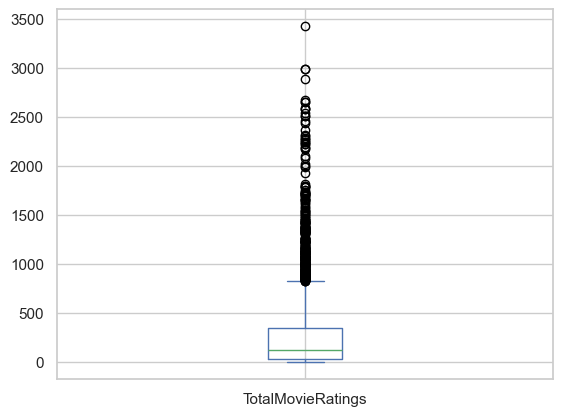

In [14]:
ratings.select("MovieID", "TotalMovieRatings").unique().to_pandas()["TotalMovieRatings"].plot(kind="box")

In [44]:
ratings.describe()

statistic,UserID,MovieID,Rating,Timestamp,Title,Genres,ReleaseYear,Year,Month,Day,Weekday,Hour,WeekdayName,IsWeekend,AvgMovieRating,TotalMovieRatings,AvgUserRating,TotalUserRatings
str,f64,f64,f64,str,str,str,str,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64
"""count""",1.000209e6,1.000209e6,1.000209e6,"""1000209""","""1000209""","""1000209""","""1000209""",1.000209e6,1.000209e6,1.000209e6,1.000209e6,1.000209e6,"""1000209""",1.000209e6,1.000209e6,1.000209e6,1.000209e6,1.000209e6
"""null_count""",0.0,0.0,0.0,"""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",3024.512348,1865.539898,3.581564,"""2000-10-22 19:41:35.404665""",null,null,null,2000.126168,8.710371,15.440691,3.800285,11.9162,null,0.383028,3.581561,816.23552,3.58156,389.908044
"""std""",1728.412695,1096.040689,1.117102,null,null,null,null,0.422392,2.71747,8.888445,2.04252,7.894465,null,null,0.545762,662.781251,0.436136,324.740247
"""min""",1.0,1.0,1.0,"""2000-04-25 23:05:32""","""$1,000,000 Duck (1971)""","""Action""","""1919""",2000.0,1.0,1.0,1.0,0.0,"""Friday""",0.0,1.0,1.0,1.015,20.0
"""25%""",1506.0,1030.0,3.0,"""2000-08-03 11:37:17""",null,null,null,2000.0,7.0,7.0,2.0,4.0,null,null,3.262,315.0,3.32,147.0
"""50%""",3070.0,1835.0,4.0,"""2000-10-31 18:46:46""",null,null,null,2000.0,9.0,17.0,4.0,14.0,null,null,3.68,645.0,3.615,302.0
"""75%""",4476.0,2770.0,4.0,"""2000-11-26 06:42:19""",null,null,null,2000.0,11.0,22.0,6.0,19.0,null,null,3.976,1124.0,3.883,544.0
"""max""",6040.0,3952.0,5.0,"""2003-02-28 17:49:50""","""eXistenZ (1999)""","""Western""","""2000""",2003.0,12.0,31.0,7.0,23.0,"""Wednesday""",1.0,5.0,3428.0,4.963,2314.0


In [42]:
weighted_ratings=ratings.select("MovieID", "TotalMovieRatings", "AvgMovieRating").unique().with_columns(
    WeightedAverageMovieRating=(((pl.col("TotalMovieRatings") * pl.col("AvgMovieRating")
                        ) + pl.lit(350))/(pl.lit(100)+pl.col("TotalMovieRatings")))
)
weighted_ratings

MovieID,TotalMovieRatings,AvgMovieRating,WeightedAverageMovieRating
i64,i64,f64,f64
906,187,4.096,3.888334
3717,584,2.974,3.050901
1542,238,3.542,3.529574
3017,104,2.529,3.00498
3040,315,3.311,3.356542
…,…,…,…
2891,185,3.492,3.494807
3241,57,3.667,3.560631
2728,426,4.019,3.920331


In [43]:
weighted_ratings.describe()

statistic,MovieID,TotalMovieRatings,AvgMovieRating,WeightedAverageMovieRating
str,f64,f64,f64,f64
"""count""",3706.0,3706.0,3706.0,3706.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",1995.573125,269.889099,3.23889,3.434259
"""std""",1151.148045,384.047838,0.672922,0.332625
"""min""",1.0,1.0,1.0,2.038376
"""25%""",989.0,33.0,2.822,3.263614
"""50%""",2034.0,124.0,3.332,3.466667
"""75%""",2991.0,350.0,3.741,3.595861
"""max""",3952.0,3428.0,5.0,4.509663


In [44]:
ratings=ratings.join(weighted_ratings.select("MovieID", "WeightedAverageMovieRating"), on="MovieID", how="left")
ratings.head()

UserID,MovieID,Rating,Timestamp,Title,Genres,ReleaseYear,Year,Month,Day,Weekday,Hour,WeekdayName,IsWeekend,AvgMovieRating,TotalMovieRatings,AvgUserRating,TotalUserRatings,WeightedAverageMovieRating
i64,i64,i64,datetime[μs],str,str,str,i32,i8,i8,i8,i8,str,bool,f64,i64,f64,i64,f64
42,24,5,2000-12-28 21:52:22,"""Powder (1995)""","""Drama|Sci-Fi""","""1995""",2000,12,28,4,21,"""Thursday""",false,3.179,624,3.74,231,3.223337
42,196,4,2000-12-28 21:46:59,"""Species (1995)""","""Horror|Sci-Fi""","""1995""",2000,12,28,4,21,"""Thursday""",false,2.824,550,3.74,231,2.928
42,1073,4,2000-12-28 22:08:02,"""Willy Wonka and the Chocolate …","""Adventure|Children's|Comedy|Fa…","""1971""",2000,12,28,4,22,"""Thursday""",false,3.861,1313,3.74,231,3.835452
42,1097,4,2000-12-28 21:33:35,"""E.T. the Extra-Terrestrial (19…","""Children's|Drama|Fantasy|Sci-F…","""1982""",2000,12,28,4,21,"""Thursday""",false,3.965,2269,3.74,231,3.945371
42,1663,4,2000-12-28 22:17:39,"""Stripes (1981)""","""Comedy""","""1981""",2000,12,28,4,22,"""Thursday""",false,3.839,740,3.74,231,3.798643


In [45]:
combined = ratings.join(users, on="UserID")
combined.head()

UserID,MovieID,Rating,Timestamp,Title,Genres,ReleaseYear,Year,Month,Day,Weekday,Hour,WeekdayName,IsWeekend,AvgMovieRating,TotalMovieRatings,AvgUserRating,TotalUserRatings,WeightedAverageMovieRating,Gender,Age,ZipCode,OccupationName,AgeCategory
i64,i64,i64,datetime[μs],str,str,str,i32,i8,i8,i8,i8,str,bool,f64,i64,f64,i64,f64,str,i64,str,str,str
42,24,5,2000-12-28 21:52:22,"""Powder (1995)""","""Drama|Sci-Fi""","""1995""",2000,12,28,4,21,"""Thursday""",false,3.179,624,3.74,231,3.223337,"""M""",25,"""24502""","""farmer""","""25-34"""
42,196,4,2000-12-28 21:46:59,"""Species (1995)""","""Horror|Sci-Fi""","""1995""",2000,12,28,4,21,"""Thursday""",false,2.824,550,3.74,231,2.928,"""M""",25,"""24502""","""farmer""","""25-34"""
42,1073,4,2000-12-28 22:08:02,"""Willy Wonka and the Chocolate …","""Adventure|Children's|Comedy|Fa…","""1971""",2000,12,28,4,22,"""Thursday""",false,3.861,1313,3.74,231,3.835452,"""M""",25,"""24502""","""farmer""","""25-34"""
42,1097,4,2000-12-28 21:33:35,"""E.T. the Extra-Terrestrial (19…","""Children's|Drama|Fantasy|Sci-F…","""1982""",2000,12,28,4,21,"""Thursday""",false,3.965,2269,3.74,231,3.945371,"""M""",25,"""24502""","""farmer""","""25-34"""
42,1663,4,2000-12-28 22:17:39,"""Stripes (1981)""","""Comedy""","""1981""",2000,12,28,4,22,"""Thursday""",false,3.839,740,3.74,231,3.798643,"""M""",25,"""24502""","""farmer""","""25-34"""


In [46]:
combined=db.sql(""" 
select *,
       case
        when AvgMovieRating >=4.0 then 'Good' 
        when AvgMovieRating < 3.0 then 'Bad'
       else 'Average'
       end as MovieClass
    from  combined
""").pl()

In [47]:
combined.write_parquet("../data/processed/combined.parquet")
ratings.write_parquet("../data/processed/ratings.parquet")
users.write_parquet("../data/processed/users.parquet")
movies.write_parquet("../data/processed/movies.parquet")

# EDA

In [47]:
ratings = pl.read_parquet("../data/processed/ratings.parquet")
users = pl.read_parquet("../data/processed/users.parquet")
combined = pl.read_parquet("../data/processed/combined.parquet")

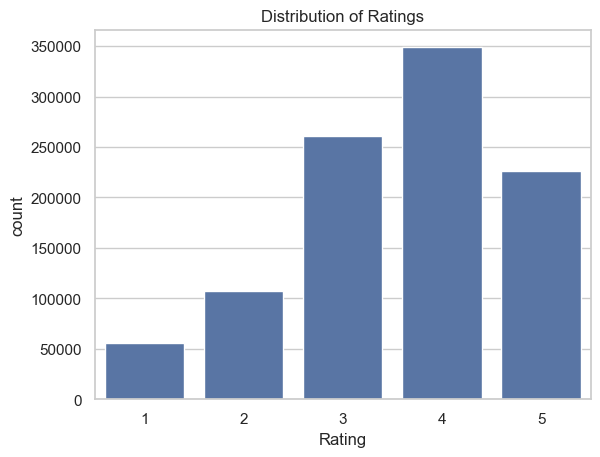

In [73]:
sns.countplot(data=combined, x="Rating")
plt.title("Distribution of Ratings");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- Above plot shows distribution of ratings given by users.

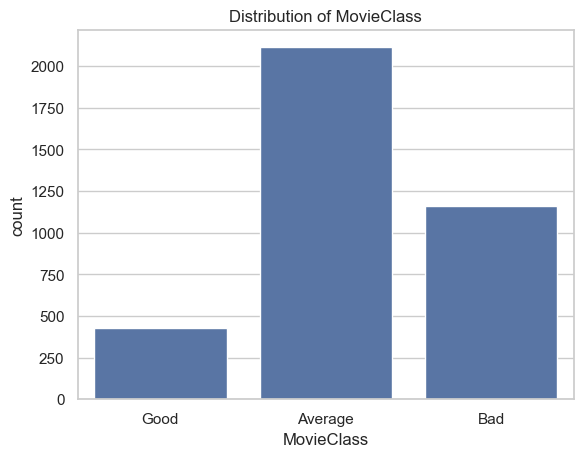

In [49]:
sns.countplot(data=combined.select("MovieID", "MovieClass").unique(), x="MovieClass")
plt.title("Distribution of MovieClass");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- we can see that majority of the movies are rated as average

In [74]:
combined["Title"].value_counts().sort("count",  descending=True).head(10)

Title,count
str,u32
"""American Beauty (1999)""",3428
"""Star Wars: Episode IV - A New …",2991
"""Star Wars: Episode V - The Emp…",2990
"""Star Wars: Episode VI - Return…",2883
"""Jurassic Park (1993)""",2672
"""Saving Private Ryan (1998)""",2653
"""Terminator 2: Judgment Day (19…",2649
"""Matrix, The (1999)""",2590
"""Back to the Future (1985)""",2583


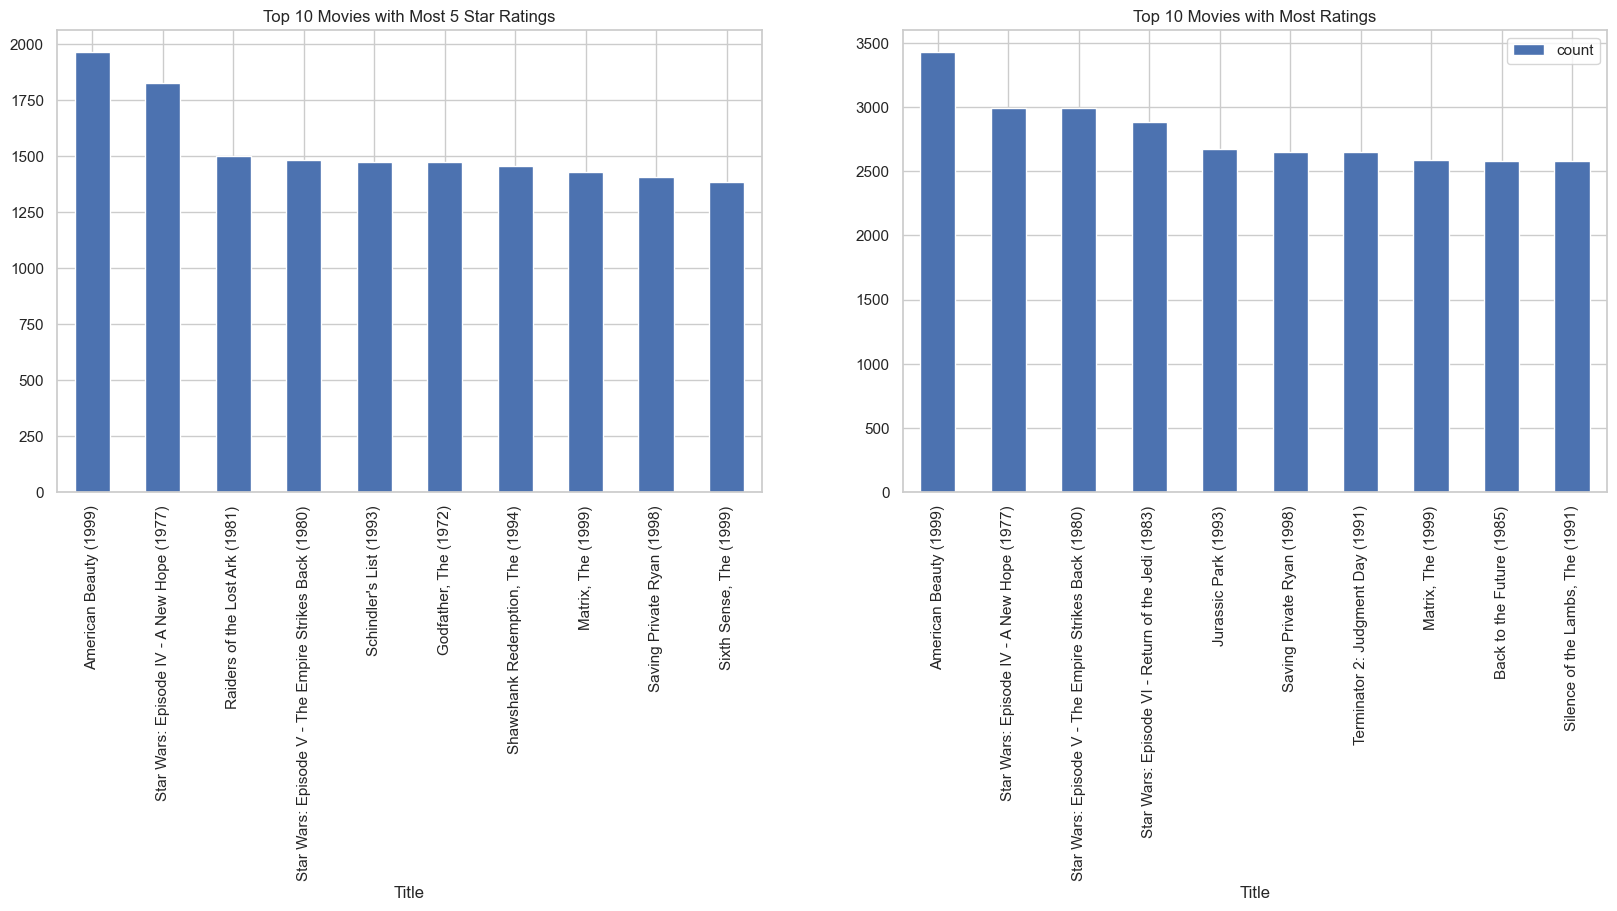

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

combined.filter(pl.col("Rating") == 5).group_by("Title").agg(pl.count("Rating").alias("Count")).sort("Count", descending=True).head(10).to_pandas().plot(kind="bar", x="Title", y="Count", legend=False, ax=ax[0])
ax[0].set_title("Top 10 Movies with Most 5 Star Ratings");

combined["Title"].value_counts().sort("count",  descending=True).head(10).to_pandas().plot(kind="bar", x="Title", y="count", ax=ax[1])
ax[1].set_title("Top 10 Movies with Most Ratings");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- Above plot shows the top 10 5 star rated movies.

In [77]:
users["Gender"].value_counts()

Gender,count
str,u32
"""F""",1709
"""M""",4331


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- We can see that there are more Male users then Female users

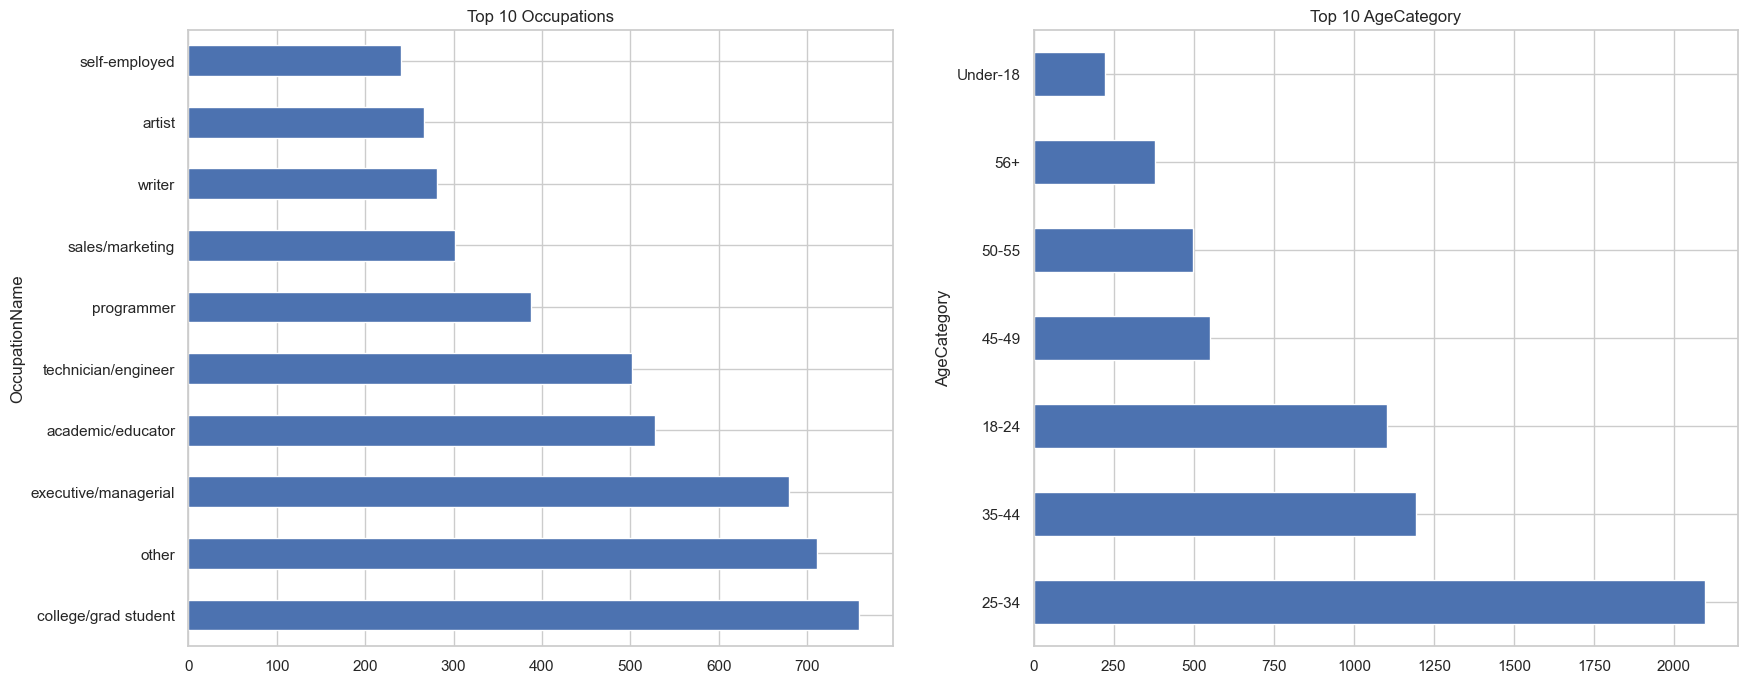

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
users["OccupationName"].value_counts().sort("count", descending=True).head(10).to_pandas().plot(kind="barh", x="OccupationName", y="count", legend=False, ax=ax[0] );
ax[0].set_title("Top 10 Occupations");
users["AgeCategory"].value_counts().sort("count", descending=True).head(10).to_pandas().plot(kind="barh", x="AgeCategory", y="count", legend=False, ax=ax[1] );
ax[1].set_title("Top 10 AgeCategory");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We can see that most of the users are from College/Grad students category
- we can also see that most of the users belong to  25-34 age group

Examine user demographics and their
potential influence on movie
preferences

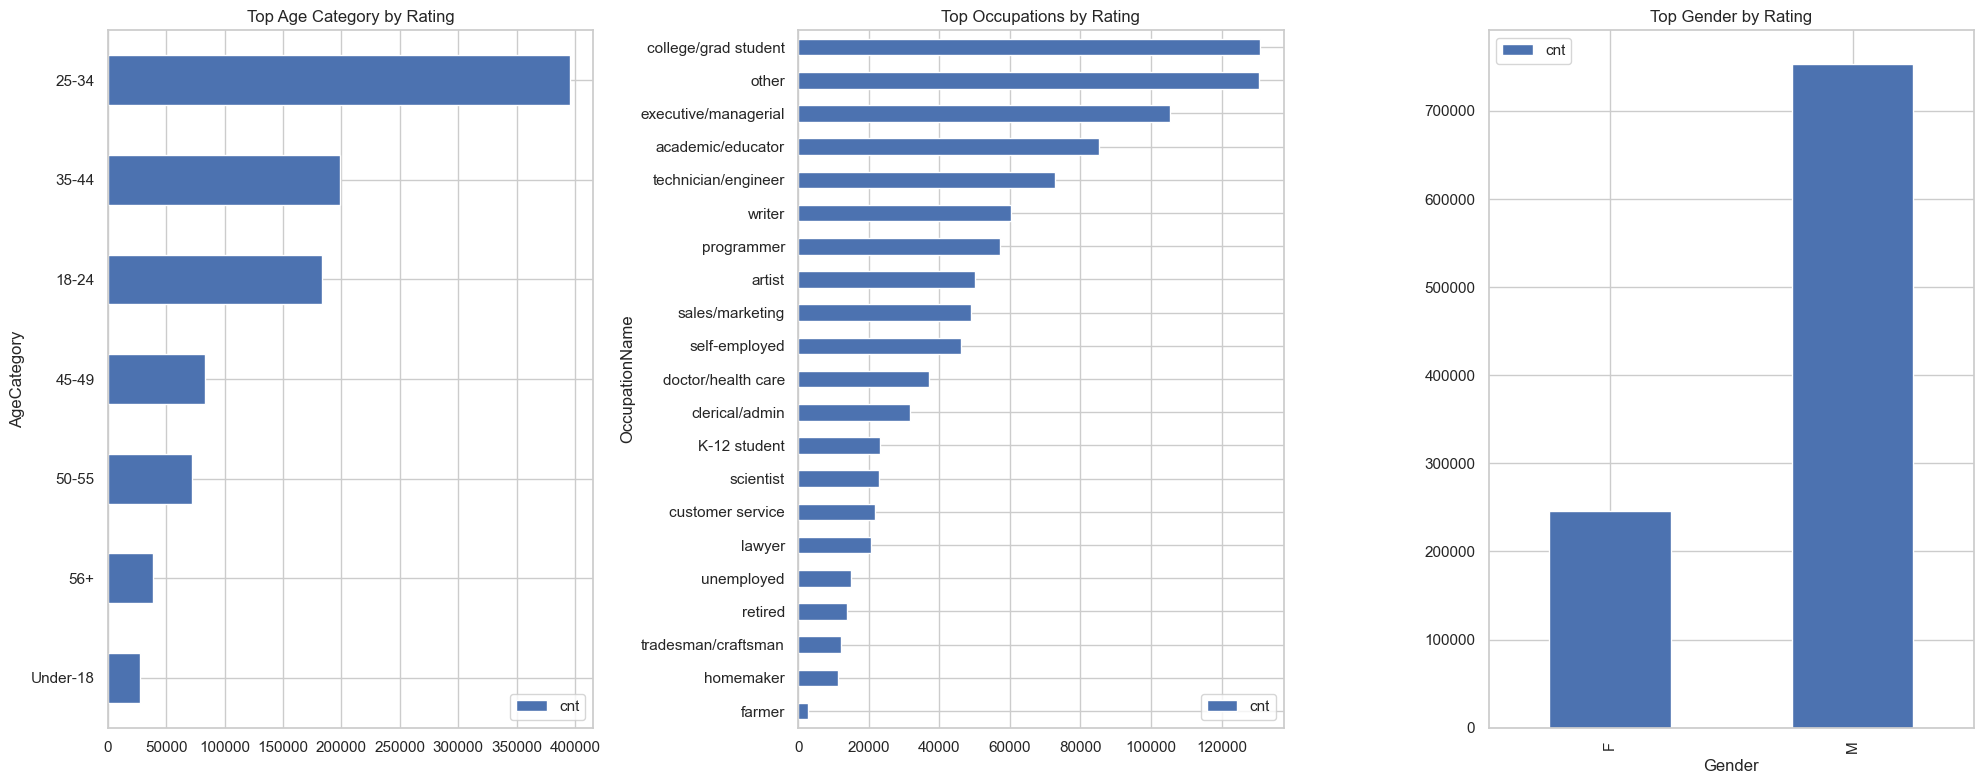

In [79]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

db.sql("""
select AgeCategory, count(*) cnt from combined group by AgeCategory order by cnt 
""").to_df().plot(kind="barh", x="AgeCategory", y="cnt", ax=ax[0] );
ax[0].set_title("Top Age Category by Rating");

db.sql("""
select OccupationName, count(*) cnt from combined group by OccupationName order by cnt 
""").to_df().plot(kind="barh", x="OccupationName", y="cnt", ax=ax[1] );
ax[1].set_title("Top Occupations by Rating");

db.sql("""
select Gender, count(*) cnt from combined group by Gender order by cnt 
""").to_df().plot(kind="bar", x="Gender", y="cnt", ax=ax[2] );
ax[2].set_title("Top Gender by Rating");
plt.tight_layout()

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- We can see that users with ages between 25-35 have rated the highest movies
- We can see that college/grad students have highest rated movies
- Most the users who have rated the movies are male

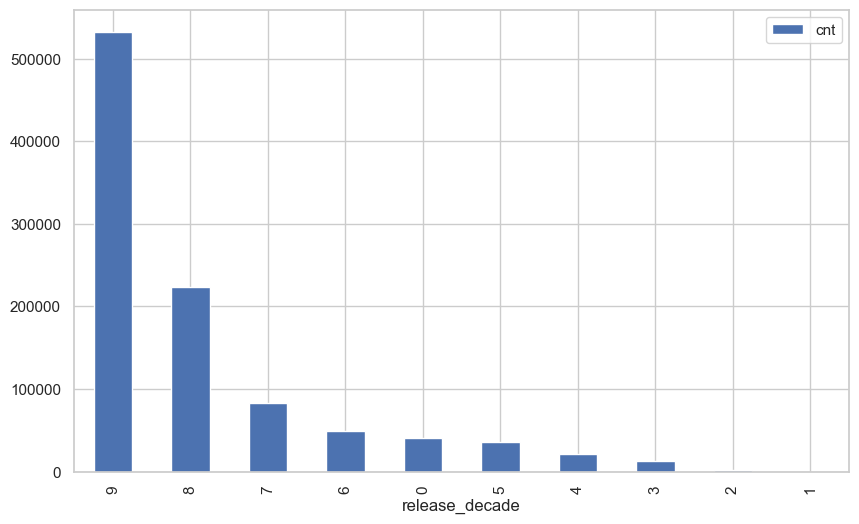

In [81]:
db.sql("""
       select 
       substring(ReleaseYear, 3,1) release_decade,
       count(*) cnt from combined 
       group by release_decade order by cnt desc""").to_df().plot(kind="bar", x="release_decade", y="cnt", figsize=(10, 6));

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- From above plot we can see that most odf the movies were released in 90's decade

https://builtin.com/data-science/recommender-systems

# Pearson Correlation Recommender

## Item-Item Similarity Based Collaborative Filtering

In [133]:
movies = pd.read_parquet("../data/processed/movies.parquet")
ratings = pd.read_parquet("../data/processed/ratings.parquet", engine ='fastparquet')
users = pd.read_parquet("../data/processed/users.parquet")

**Pivot Table**

In [80]:
rating_pivot = ratings.pivot_table(values="Rating", index="UserID", columns="MovieID").fillna(0)
rating_pivot.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Correlation Matrix**

In [81]:
movie_corr = rating_pivot.corr()
movie_corr.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
MovieID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.262649,0.146536,0.109375,0.170156,0.168087,0.189333,0.082963,0.045705,0.215653,...,0.039913,0.002483,0.054038,0.018530,-0.007335,0.132009,0.076941,0.050559,-0.002849,0.052121
2,0.262649,1.000000,0.169586,0.111616,0.196561,0.137334,0.193658,0.173878,0.126871,0.302042,...,0.025345,0.004734,0.055814,0.061466,0.047608,0.108027,0.075658,0.060941,0.000489,0.045883
3,0.146536,0.169586,1.000000,0.158659,0.268062,0.095834,0.238816,0.068058,0.100622,0.164252,...,0.007877,0.058906,0.032291,0.059063,0.028135,0.104775,0.050016,0.039715,-0.011203,0.034831
4,0.109375,0.111616,0.158659,1.000000,0.247529,0.071081,0.187311,0.034228,0.042133,0.082035,...,0.037847,0.048747,-0.008854,0.007128,0.011165,0.067022,0.064363,0.008411,0.012596,0.058965
5,0.170156,0.196561,0.268062,0.247529,1.000000,0.075012,0.264749,0.076378,0.116465,0.176002,...,0.002233,0.078781,0.032615,0.023873,-0.002865,0.107924,0.048976,0.033442,-0.005872,0.064648


In [82]:
with open("../models/movie_corr.pkl", "wb") as f:
    pickle.dump(movie_corr, f)

In [2]:
with open("../models/movie_corr.pkl", "rb") as f:
    movie_corr = pickle.load(f)

### Recommendation based only on movie id

In [109]:
movies

,MovieID,Title,Genres,ReleaseYear
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,2000
3879,3949,Requiem for a Dream (2000),Drama,2000
3880,3950,Tigerland (2000),Drama,2000
3881,3951,Two Family House (2000),Drama,2000


In [108]:
random_movie = movies.sample(1)
random_movie_id = random_movie["MovieID"].values[0]
random_movie

,MovieID,Title,Genres,ReleaseYear
1736,1796,In God's Hands (1998),Action|Drama,1998


In [112]:
top_n_movies=movie_corr.loc[648].sort_values(ascending=False)
top_n_movies = top_n_movies[top_n_movies.index != random_movie_id]
top_n_movies=top_n_movies[:10]
top_n_movies

MovieID
648     1.000000
380     0.492173
733     0.487349
10      0.468448
1552    0.465473
1370    0.456723
1377    0.448973
349     0.448161
165     0.442651
1608    0.441444
Name: 648, dtype: float64

In [113]:
pd.DataFrame(top_n_movies.index).merge(movies, on="MovieID")

,MovieID,Title,Genres,ReleaseYear
0,648,Mission: Impossible (1996),Action|Adventure|Mystery,1996
1,380,True Lies (1994),Action|Adventure|Comedy|Romance,1994
2,733,"Rock, The (1996)",Action|Adventure|Thriller,1996
3,10,GoldenEye (1995),Action|Adventure|Thriller,1995
4,1552,Con Air (1997),Action|Adventure|Thriller,1997
5,1370,Die Hard 2 (1990),Action|Thriller,1990
6,1377,Batman Returns (1992),Action|Adventure|Comedy|Crime,1992
7,349,Clear and Present Danger (1994),Action|Adventure|Thriller,1994
8,165,Die Hard: With a Vengeance (1995),Action|Thriller,1995
9,1608,Air Force One (1997),Action|Thriller,1997


In [114]:
def recommend_movies_by_movie_id(movie_id, n=10):
    print(f"Recommendation for movie: {movies[movies['MovieID'] == movie_id]['Title'].values[0]}")
    top_n_movies=movie_corr.loc[movie_id].sort_values(ascending=False)
    top_n_movies = top_n_movies[top_n_movies.index != movie_id]
    top_n_movies=top_n_movies[:n]
    return pd.DataFrame(top_n_movies.index).merge(movies, on="MovieID")

In [115]:
recommend_movies_by_movie_id(123)

Recommendation for movie: Chungking Express (1994)


,MovieID,Title,Genres,ReleaseYear
0,1236,Trust (1990),Comedy|Drama,1990
1,1218,"Killer, The (Die xue shuang xiong) (1989)",Action|Thriller,1989
2,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Drama,1995
3,1279,Night on Earth (1991),Comedy|Drama,1991
4,247,Heavenly Creatures (1994),Drama|Fantasy|Romance|Thriller,1994
5,3265,Hard-Boiled (Lashou shentan) (1992),Action|Crime,1992
6,1809,Hana-bi (1997),Comedy|Crime|Drama,1997
7,446,Farewell My Concubine (1993),Drama|Romance,1993
8,319,Shallow Grave (1994),Thriller,1994
9,2348,Sid and Nancy (1986),Drama,1986


### Recommendation based user id

In [89]:
# source chatgpt
def calculate_dynamic_threshold(similarity_row):
    """
    Calculates a dynamic threshold based on the similarity distribution for a movie.
    Ignores NaN and negative values, and uses the 25th percentile as the threshold.

    Args:
        similarity_row (np.ndarray): Row of similarity scores for a movie.

    Returns:
        float: Dynamic threshold for the movie.
    """
    valid_similarities = similarity_row[~np.isnan(similarity_row) & (similarity_row > 0)]
    if len(valid_similarities) == 0:
        return 0  # No valid similarities, set threshold to 0
    return np.percentile(valid_similarities, 25)  # 25th percentile

In [142]:
def recommend_movies_by_user_id(user_id, n=10):
    user_rated_movies = rating_pivot.loc[user_id][rating_pivot.loc[user_id] > 0].index
    movie_ratings = rating_pivot.loc[user_id].to_dict()
    unrated_movies = rating_pivot.loc[user_id][rating_pivot.loc[user_id] == 0].index

    similarity_score={}
    for movie_id in unrated_movies:
        numerator = 0
        denominator = 0
        threshold = calculate_dynamic_threshold(movie_corr[movie_id])
        for rated_movie in user_rated_movies:
            sim=movie_corr.loc[movie_id, rated_movie]
            if sim > threshold:
                numerator += sim * movie_ratings[rated_movie]
                denominator += abs(sim)
        similarity_score[movie_id] = numerator / denominator if denominator != 0 else 0
    return pd.DataFrame(similarity_score.items(), columns=["MovieID", "PredictedRating"]).sort_values("PredictedRating", ascending=False).merge(movies, on="MovieID").head(10)

In [143]:
recommend_movies_by_user_id(1)

,MovieID,PredictedRating,Title,Genres,ReleaseYear
0,1915,5.000000,Voyage to the Beginning of the World (1997),Drama,1997
1,3216,4.751446,Vampyros Lesbos (Las Vampiras) (1970),Horror,1970
2,3621,4.671628,Possession (1981),Drama|Horror,1981
3,878,4.591584,Bye-Bye (1995),Drama,1995
4,1433,4.581080,"Machine, The (1994)",Comedy|Horror,1994
5,2740,4.550616,"Kindred, The (1986)",Horror,1986
6,1787,4.549433,Paralyzing Fear: The Story of Polio in America...,Documentary,1998
7,989,4.533011,Schlafes Bruder (Brother of Sleep) (1995),Drama,1995
8,3881,4.532808,Bittersweet Motel (2000),Documentary,2000
9,3123,4.528056,Spring Fever USA (a.k.a. Lauderdale) (1989),Comedy,1989


# Cosine Similarity

## Item-Item Similarity Based Collaborative Filtering

In [ ]:
movies = pl.read_parquet('../data/processed/movies.parquet')
ratings = pd.read_parquet('../data/processed/ratings.parquet', engine='fastparquet')
users = pd.read_parquet("../data/processed/users.parquet")

**Pivot Table**

In [26]:
rating_pivot = ratings.pivot_table(values="Rating", index="MovieID", columns="UserID").fillna(0)
rating_pivot.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
MovieID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


**Ratings based similarity matrix**

In [29]:
cos_similarity = cosine_similarity(rating_pivot)
rating_based_movie_similarity_df = pd.DataFrame(cos_similarity, index=rating_pivot.index, columns=rating_pivot.index)
rating_based_movie_similarity_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
MovieID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.390349,0.267943,0.178789,0.256569,0.347373,0.301490,0.125709,0.106620,0.377459,...,0.099502,0.020966,0.084105,0.081826,0.045949,0.309676,0.186633,0.093479,0.042829,0.182691
2,0.390349,1.000000,0.240946,0.155457,0.249970,0.244827,0.262772,0.196521,0.158469,0.386200,...,0.061819,0.015209,0.075310,0.095573,0.074271,0.213650,0.140781,0.087013,0.026063,0.122185
3,0.267943,0.240946,1.000000,0.192788,0.308290,0.187020,0.292230,0.092122,0.128378,0.245601,...,0.038492,0.065507,0.049512,0.087377,0.050985,0.190575,0.104837,0.062258,0.010073,0.097786
4,0.178789,0.155457,0.192788,1.000000,0.271990,0.125170,0.220024,0.049554,0.060334,0.133707,...,0.055486,0.053300,0.002227,0.025278,0.025204,0.118902,0.096318,0.022588,0.024769,0.095154
5,0.256569,0.249970,0.308290,0.271990,1.000000,0.148114,0.305107,0.095512,0.138392,0.237681,...,0.026632,0.083898,0.046399,0.047542,0.016156,0.174554,0.092403,0.051633,0.010750,0.112835


In [30]:
ratings.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,ReleaseYear,Year,Month,Day,Weekday,Hour,WeekdayName,IsWeekend,AvgMovieRating,TotalMovieRatings,AvgUserRating,TotalUserRatings
0,12,1641,3,2000-12-30 23:22:48,"Full Monty, The (1997)",Comedy,1997,2000,12,30,6,23,Saturday,False,3.872,1199,3.826,23
1,12,3265,4,2000-12-30 23:28:36,Hard-Boiled (Lashou shentan) (1992),Action|Crime,1992,2000,12,30,6,23,Saturday,False,4.138,327,3.826,23
2,12,3658,4,2000-12-30 23:50:16,Quatermass and the Pit (1967),Sci-Fi,1967,2000,12,30,6,23,Saturday,False,3.652,69,3.826,23
3,12,2616,1,2000-12-30 23:22:48,Dick Tracy (1990),Action|Crime,1990,2000,12,30,6,23,Saturday,False,2.683,624,3.826,23
4,12,3897,4,2000-12-30 23:29:09,Almost Famous (2000),Comedy|Drama,2000,2000,12,30,6,23,Saturday,False,4.226,994,3.826,23


In [31]:
ratings=ratings[["MovieID", "AvgMovieRating", "TotalMovieRatings"]].drop_duplicates()
ratings.shape

(3706, 3)

In [32]:
movies.head()

MovieID,Title,Genres,ReleaseYear
i64,str,str,str
1,"""Toy Story (1995)""","""Animation|Children's|Comedy""","""1995"""
2,"""Jumanji (1995)""","""Adventure|Children's|Fantasy""","""1995"""
3,"""Grumpier Old Men (1995)""","""Comedy|Romance""","""1995"""
4,"""Waiting to Exhale (1995)""","""Comedy|Drama""","""1995"""
5,"""Father of the Bride Part II (1…","""Comedy""","""1995"""


In [33]:
movies=movies.with_columns(
    pl.col("Genres").str.split("|").alias("Genres")
).explode("Genres").to_pandas()
movies.head()

,MovieID,Title,Genres,ReleaseYear
0,1,Toy Story (1995),Animation,1995
1,1,Toy Story (1995),Children's,1995
2,1,Toy Story (1995),Comedy,1995
3,2,Jumanji (1995),Adventure,1995
4,2,Jumanji (1995),Children's,1995


In [34]:
movies_pivot = movies.pivot_table(index="MovieID", columns="Genres", aggfunc='size', fill_value=0)
movies_pivot

Genres,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
MovieID,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3949,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3950,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [35]:
movies_pivot=movies_pivot.reset_index()

In [36]:
movies_df=movies_pivot.merge(ratings, on="MovieID", how="left").fillna(0)
movies_df = movies_df.set_index("MovieID")
movies_df.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,AvgMovieRating,TotalMovieRatings
MovieID,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4.147,2077.0
2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3.201,701.0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3.017,478.0
4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2.729,170.0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.007,296.0


In [37]:
sc=StandardScaler()
movies_df_scaled=sc.fit_transform(movies_df)
movies_df_scaled

array([[-0.38576751, -0.28037673,  5.99841249, ..., -0.13350797,
         1.12006327,  4.79623255],
       [-0.38576751,  3.56662979, -0.16671078, ..., -0.13350797,
         0.11643486,  1.16890068],
       [-0.38576751, -0.28037673, -0.16671078, ..., -0.13350797,
        -0.07877405,  0.58104094],
       ...,
       [-0.38576751, -0.28037673, -0.16671078, ..., -0.13350797,
         0.61082264, -0.53668342],
       [-0.38576751, -0.28037673, -0.16671078, ..., -0.13350797,
         0.85801653, -0.57358941],
       [-0.38576751, -0.28037673, -0.16671078, ..., -0.13350797,
         0.73176729,  0.34378813]])

In [123]:
movies_df_scaled=pd.DataFrame(movies_df_scaled, columns=movies_df.columns, index=movies_df.index)

In [124]:
movies_df_scaled.to_parquet("../data/processed/movies_df_scaled.parquet")

**Movies features based similarity matrix**

In [38]:
cos_similarity_matrix = cosine_similarity(movies_df_scaled)
features_based_movie_similarity_df = pd.DataFrame(cos_similarity_matrix , index=movies_pivot["MovieID"], columns=movies_pivot["MovieID"])

In [39]:
features_based_movie_similarity_df

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
MovieID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.214883,0.114197,-0.070673,0.126977,0.089959,0.121087,0.218764,-0.187190,0.075936,...,-0.012860,-0.188402,0.619093,-0.227593,-0.170745,0.438119,-0.071367,-0.297797,-0.276489,-0.061829
2,0.214883,1.000000,-0.092706,-0.217185,-0.126030,-0.038100,-0.092920,0.546101,-0.095381,0.239267,...,-0.155741,-0.217542,0.341691,-0.144834,-0.095539,-0.021251,-0.129380,-0.185864,-0.176879,-0.112546
3,0.114197,-0.092706,1.000000,0.135416,0.428231,-0.136309,0.992276,-0.155519,-0.173579,-0.152016,...,0.374468,0.097010,-0.135699,-0.328026,-0.184498,0.418960,-0.313237,-0.390295,-0.375893,-0.288543
4,-0.070673,-0.217185,0.135416,1.000000,0.514122,-0.378870,0.115308,-0.249094,-0.279179,-0.399782,...,0.526790,0.951543,-0.184879,-0.046030,-0.319962,0.288021,0.222536,0.319213,0.282743,-0.009541
5,0.126977,-0.126030,0.428231,0.514122,1.000000,-0.208928,0.420986,-0.136069,-0.071495,-0.227369,...,0.965647,0.459594,-0.143302,-0.392635,-0.084687,0.780391,-0.265488,-0.291218,-0.282444,-0.337866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.438119,-0.021251,0.418960,0.288021,0.780391,0.045243,0.435800,-0.160179,-0.171070,0.018524,...,0.611824,0.093331,-0.200913,-0.411170,-0.130462,1.000000,-0.030609,-0.302047,-0.269999,-0.138255
3949,-0.071367,-0.129380,-0.313237,0.222536,-0.265488,-0.143745,-0.247259,-0.167237,-0.202703,-0.194180,...,-0.263223,0.045474,-0.277147,-0.049866,-0.049751,-0.030609,1.000000,0.915673,0.933331,0.397815
3950,-0.297797,-0.185864,-0.390295,0.319213,-0.291218,-0.292791,-0.345050,-0.143393,-0.131373,-0.334119,...,-0.203880,0.246525,-0.221407,0.035355,-0.025689,-0.302047,0.915673,1.000000,0.993111,0.331591


In [42]:
user_rating_pivot=rating_pivot.T
user_rating_pivot

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**User Ratings based similarity matrix**

In [44]:
cos_similarity_matrix = cosine_similarity(user_rating_pivot)
user_rating_based_similarity_df = pd.DataFrame(cos_similarity_matrix, index=user_rating_pivot.index, columns=user_rating_pivot.index)
user_rating_based_similarity_df

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.096382,0.120610,0.132455,0.090158,0.179222,0.059678,0.138241,0.226148,0.255288,...,0.170588,0.082006,0.069807,0.033663,0.114877,0.186329,0.135979,0.000000,0.174604,0.133590
2,0.096382,1.000000,0.151479,0.171176,0.114394,0.100865,0.305787,0.203337,0.190198,0.226861,...,0.112503,0.091222,0.268565,0.014286,0.183384,0.228241,0.206274,0.066118,0.066457,0.218276
3,0.120610,0.151479,1.000000,0.151227,0.062907,0.074603,0.138332,0.077656,0.126457,0.213655,...,0.092960,0.125864,0.161507,0.000000,0.097308,0.143264,0.107744,0.120234,0.094675,0.133144
4,0.132455,0.171176,0.151227,1.000000,0.045094,0.013529,0.130339,0.100856,0.093651,0.120738,...,0.163629,0.093041,0.382803,0.000000,0.082097,0.170583,0.127464,0.062907,0.064634,0.137968
5,0.090158,0.114394,0.062907,0.045094,1.000000,0.047449,0.126257,0.220817,0.261330,0.117052,...,0.100652,0.035732,0.061806,0.054151,0.179083,0.293365,0.172686,0.020459,0.027689,0.241437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.186329,0.228241,0.143264,0.170583,0.293365,0.093583,0.122441,0.227400,0.239607,0.338072,...,0.131294,0.209843,0.186426,0.103431,0.267405,1.000000,0.341462,0.124174,0.219115,0.411891
6037,0.135979,0.206274,0.107744,0.127464,0.172686,0.065788,0.111673,0.144395,0.225055,0.246902,...,0.142309,0.276134,0.129985,0.118749,0.141676,0.341462,1.000000,0.049015,0.252146,0.428240
6038,0.000000,0.066118,0.120234,0.062907,0.020459,0.065711,0.000000,0.019242,0.093470,0.113789,...,0.108837,0.106897,0.040689,0.000000,0.063967,0.124174,0.049015,1.000000,0.161714,0.099300


In [ ]:
users=users.drop(["OccupationName", "AgeCategory"], axis=1)

,UserID,Gender,Age,Occupation,ZipCode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [62]:
users["Gender"]=users["Gender"].map({
    "M":1,
    "F":0
})

In [76]:
users["ZipCode"]=users["ZipCode"].astype(str).str.extract(r"(\d{1})").astype(int)

In [78]:
users.head()

,UserID,Gender,Age,Occupation,ZipCode
0,1,0,1,10,4
1,2,1,56,16,7
2,3,1,25,15,5
3,4,1,45,7,0
4,5,1,25,20,5


In [ ]:
encoder = OneHotEncoder(sparse_output=False)
occupation_one_hot = encoder.fit_transform(users["Occupation"].values.reshape(-1, 1))
occupation_one_hot_df = pd.DataFrame(occupation_one_hot, columns=encoder.get_feature_names_out(["Occupation"]))
occupation_one_hot_df.head()

,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9,...,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [82]:
encoder = OneHotEncoder(sparse_output=False)
zipCode_one_hot = encoder.fit_transform(users["ZipCode"].values.reshape(-1, 1))
zipCode_one_hot_df = pd.DataFrame(zipCode_one_hot, columns=encoder.get_feature_names_out(["ZipCode"]))
zipCode_one_hot_df.head()

,ZipCode_0,ZipCode_1,ZipCode_2,ZipCode_3,ZipCode_4,ZipCode_5,ZipCode_6,ZipCode_7,ZipCode_8,ZipCode_9
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [83]:
users = pd.concat([users, occupation_one_hot_df, zipCode_one_hot_df], axis=1)
users = users.drop(["Occupation", "ZipCode"], axis=1)
users.head()

,UserID,Gender,Age,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,...,ZipCode_0,ZipCode_1,ZipCode_2,ZipCode_3,ZipCode_4,ZipCode_5,ZipCode_6,ZipCode_7,ZipCode_8,ZipCode_9
0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,1,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,1,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,1,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [86]:
users=users.set_index("UserID")

In [87]:
sc = StandardScaler()
users_scaled = sc.fit_transform(users)
users_scaled = pd.DataFrame(users_scaled, columns=users.columns)
users_scaled.head()

,Gender,Age,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,...,ZipCode_0,ZipCode_1,ZipCode_2,ZipCode_3,ZipCode_4,ZipCode_5,ZipCode_6,ZipCode_7,ZipCode_8,ZipCode_9
0,-1.591927,-2.298525,-0.365268,-0.309501,-0.215058,-0.171718,-0.379108,-0.137453,-0.201647,-0.355887,...,-0.350848,-0.350848,-0.280649,-0.261286,2.991751,-0.349954,-0.276855,-0.273024,-0.231011,-0.566644
1,0.628170,1.966729,-0.365268,-0.309501,-0.215058,-0.171718,-0.379108,-0.137453,-0.201647,-0.355887,...,-0.350848,-0.350848,-0.280649,-0.261286,-0.334252,-0.349954,-0.276855,3.662687,-0.231011,-0.566644
2,0.628170,-0.437323,-0.365268,-0.309501,-0.215058,-0.171718,-0.379108,-0.137453,-0.201647,-0.355887,...,-0.350848,-0.350848,-0.280649,-0.261286,-0.334252,2.857517,-0.276855,-0.273024,-0.231011,-0.566644
3,0.628170,1.113678,-0.365268,-0.309501,-0.215058,-0.171718,-0.379108,-0.137453,-0.201647,2.809882,...,2.850240,-0.350848,-0.280649,-0.261286,-0.334252,-0.349954,-0.276855,-0.273024,-0.231011,-0.566644
4,0.628170,-0.437323,-0.365268,-0.309501,-0.215058,-0.171718,-0.379108,-0.137453,-0.201647,-0.355887,...,-0.350848,-0.350848,-0.280649,-0.261286,-0.334252,2.857517,-0.276855,-0.273024,-0.231011,-0.566644


In [125]:
users_scaled.to_parquet("../data/processed/users_scaled.parquet")

**User features based similarity matrix**

In [88]:
cos_similarity_matrix = cosine_similarity(users_scaled)
user_feature_based_similarity_df = pd.DataFrame(cos_similarity_matrix, index=users.index, columns=users.index)
user_feature_based_similarity_df

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.163047,-0.040782,-0.184655,-0.053070,-0.047508,-0.121693,-0.059596,-0.057325,-0.019182,...,0.418483,-0.184437,-0.119584,-0.065764,0.039036,0.028298,-0.055279,-0.113344,-0.067826,-0.049748
2,-0.163047,1.000000,-0.052300,0.015504,-0.067918,-0.001102,-0.034173,-0.076139,-0.073387,-0.093613,...,-0.162923,0.015508,0.329356,-0.082850,0.326675,-0.074432,0.405378,0.022354,-0.030908,-0.063706
3,-0.040782,-0.052300,1.000000,-0.070649,0.218332,0.102457,-0.056982,-0.041888,-0.040110,-0.113774,...,-0.080931,0.251690,-0.040841,-0.047632,-0.075035,0.717658,-0.090995,-0.106738,-0.109848,-0.034785
4,-0.184655,0.015504,-0.070649,1.000000,-0.091840,-0.037396,0.431679,-0.103045,-0.099220,-0.162331,...,-0.209619,0.477791,-0.001334,-0.112908,-0.154773,-0.104281,-0.080490,-0.045279,0.401055,-0.086118
5,-0.053070,-0.067918,0.218332,-0.091840,1.000000,0.131277,-0.074230,-0.054735,-0.052425,-0.147344,...,-0.105011,0.322702,-0.053087,-0.062135,-0.097312,-0.065198,-0.117823,-0.138108,-0.142211,-0.045467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.028298,-0.074432,0.717658,-0.104281,-0.065198,-0.001686,-0.090273,-0.073024,-0.070461,0.003416,...,0.023645,-0.104151,-0.060101,-0.078865,0.016783,1.000000,0.000476,-0.009940,-0.001837,-0.061176
6037,-0.055279,0.405378,-0.090995,-0.080490,-0.117823,0.043866,0.389955,-0.131766,-0.127371,0.566061,...,-0.028874,-0.080378,0.335466,-0.140523,0.958921,0.000476,1.000000,0.533680,0.062862,-0.110616
6038,-0.113344,0.022354,-0.106738,-0.045279,-0.138108,0.072589,0.419142,0.237665,-0.149318,0.604709,...,-0.066659,-0.045203,-0.003204,-0.163793,0.433644,-0.009940,0.533680,1.000000,0.103484,0.201980


### Recommend movies based on movie id

In [108]:
def recommend_movies_by_movie_id(movie_id, n=10):
    print(f"Recommendation for movie: {movies[movies['MovieID'] == movie_id]['Title'].values[0]}")
    top_n_movies=rating_based_movie_similarity_df.loc[movie_id].sort_values(ascending=False)
    top_n_movies = top_n_movies[top_n_movies.index != movie_id]
    top_n_movies=top_n_movies[:n]
    return pd.DataFrame(top_n_movies.index).merge(movies, on="MovieID")

In [109]:
movies

,MovieID,Title,Genres,ReleaseYear
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,2000
3879,3949,Requiem for a Dream (2000),Drama,2000
3880,3950,Tigerland (2000),Drama,2000
3881,3951,Two Family House (2000),Drama,2000


In [110]:
recommend_movies_by_movie_id(1, 10)

Recommendation for movie: Toy Story (1995)


,MovieID,Title,Genres,ReleaseYear
0,3114,Toy Story 2 (1999),Animation|Children's|Comedy,1999
1,1265,Groundhog Day (1993),Comedy|Romance,1993
2,588,Aladdin (1992),Animation|Children's|Comedy|Musical,1992
3,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy,1998
4,1270,Back to the Future (1985),Comedy|Sci-Fi,1985
5,34,Babe (1995),Children's|Comedy|Drama,1995
6,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,1980
7,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,1997
8,356,Forrest Gump (1994),Comedy|Romance|War,1994
9,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999


# Matrix Factorization

In [29]:
from cmfrec import CMF
import optuna

In [18]:
users_scaled = pd.read_parquet("../data/processed/users_scaled.parquet")
movies_df_scaled = pd.read_parquet("../data/processed/movies_df_scaled.parquet")
ratings = pd.read_parquet("../data/processed/ratings.parquet", engine='fastparquet')

In [19]:
ratings=ratings[["UserID", "MovieID", "Rating"]]
ratings= ratings.rename(columns={"MovieID":"ItemId", "UserID":"UserId"})
users_scaled=users_scaled.reset_index().rename(columns={"index":"UserId"})
movies_df_scaled=movies_df_scaled.reset_index().rename(columns={"MovieID":"ItemId"})

In [30]:
model = CMF(method="als", k=4, lambda_=1e+1)

model.fit(
    X=ratings,
    U=users_scaled,
    I=movies_df_scaled,
)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cmfrec/__init__.py:138: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warnings.warn(msg_omp)


Collective matrix factorization model
(explicit-feedback variant)


In [21]:
predicted_rating = model.predict(user=12, item=1641)
print(f"Predicted rating for user 12 and movie 1642: {predicted_rating}")

Predicted rating for user 12 and movie 1642: 3.7841548919677734


**Using MF to create new User and Item embeddings**

In [32]:
new_A = model.A_
new_B = model.B_

new_A.shape, new_B.shape

((6041, 4), (3883, 4))

In [22]:
rating_train, rating_test = train_test_split(ratings, test_size=0.2)

In [23]:
model = CMF(method="als", lambda_=1e+1, n_jobs=-1, k=2)

model.fit(
    X=rating_train,
    U=users_scaled,
    I=movies_df_scaled,
);

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/cmfrec/__init__.py:138: UserWarning: Attempting to use more than 1 thread, but package was built without multi-threading support - see the project's GitHub page for more information.
  warnings.warn(msg_omp)


In [24]:
rating_test["PredictedRating"]=model.predict(user=rating_test["UserId"], item=rating_test["ItemId"])

In [25]:
rmse = np.sqrt(mean_squared_error(rating_test['Rating'], rating_test['PredictedRating']))
mape = mean_absolute_percentage_error(rating_test['Rating'], rating_test['PredictedRating'])
print(f"RMSE: {rmse}, MAPE: {mape}")

RMSE: 0.8764562115260532, MAPE: 0.26938785664092113


In [26]:
model.A_.shape, model.B_.shape

((6041, 2), (3883, 2))

In [ ]:
# n_components = 2
# svd = TruncatedSVD(n_components=n_components)
# A_svd = svd.fit_transform(model.A_)
# B_svd = svd.fit_transform(model.B_)
# A_svd.shape, B_svd.shape

((6041, 2), (3883, 2), (33, 2))

<Axes: >

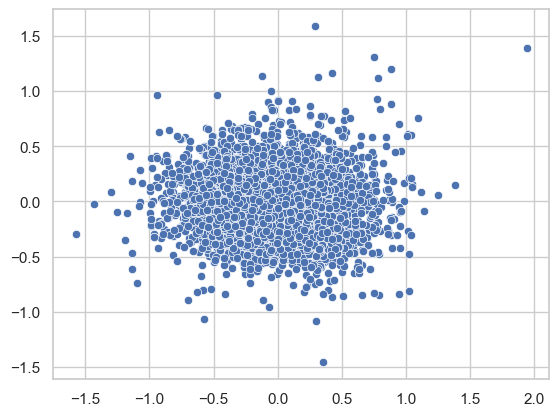

In [27]:
sns.scatterplot(x=model.A_[:, 0], y=model.A_[:, 1])

<Axes: >

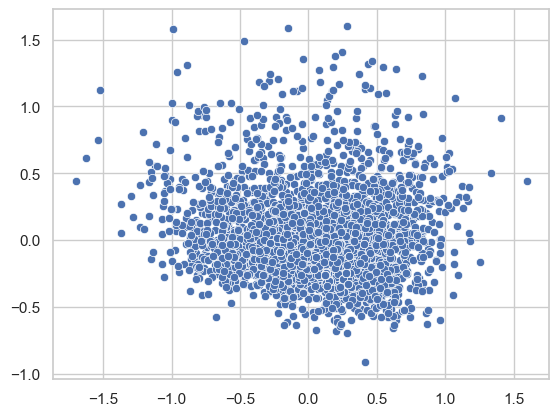

In [28]:
sns.scatterplot(x=model.B_[:, 0], y=model.B_[:, 1])

# Insights and Recommendations

- We can see that all the methods provide similar quality of results.
- But, matrix factorization provides better results as it uses latent features to recommend movies.
- Pearson and Cosine similarity based collaborative filtering methods are not able to provide good recommendations as they are based on user-item ratings.

# Other

 Sparse ‘row’ matrix representation for the following dense matrix - [[1	0],[ 3	7]]

In [16]:
from scipy.sparse import csr_matrix
A = np.array([[1,0],[3,7]])
S = csr_matrix(A)
print(S)

  (0, 0)	1
  (1, 0)	3
  (1, 1)	7
